## Dissertation Code: Hierarchical Risk Parity

#### Student Name - Triparna Chatterjee
#### Student Number - 2433119

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import seaborn as sns
import matplotlib.dates as mdates
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import and read the dataset
dat_frm = pd.read_csv('50_stock_data.csv', index_col= 0)
dat_frm.head(5)

,AAPL,ADBE,ADP,AMGN,ASML,AXP,BA,BIIB,CAT,CSCO,...,QQQ,SAP,SPY,TRV,TSM,TXN,UNH,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.380000,19.549999,31.690842,62.349998,23.096251,41.795574,41.990002,36.939999,41.325001,24.250000,...,36.360001,42.299999,111.230003,39.599998,8.619336,29.309999,29.520000,31.701126,35.709999,17.433332
2004-01-05,0.395893,19.900000,32.626656,62.349998,23.332500,42.163200,42.070000,37.099998,42.450001,24.770000,...,37.090000,44.380001,112.440002,39.700001,8.804959,29.930000,28.100000,32.618435,35.250000,17.373333
2004-01-06,0.394464,19.920000,32.935951,62.549999,23.568750,42.233227,41.930000,38.590000,41.700001,25.059999,...,37.340000,45.000000,112.550003,39.400002,8.813029,29.990000,28.389999,33.158031,35.029999,17.780001
2004-01-07,0.403393,19.719999,32.761478,63.380001,23.647499,42.355766,42.279999,40.790001,41.244999,25.559999,...,37.680000,44.470001,112.930000,39.400002,8.724253,29.950001,28.655001,32.879238,34.439999,17.826668
2004-01-08,0.417143,19.000000,32.698032,63.360001,24.761250,42.233227,42.860001,41.250000,40.924999,26.340000,...,37.980000,45.270000,113.379997,39.650002,9.039004,31.850000,28.715000,33.382862,34.470001,17.753332


In [3]:
# shape
dat_frm.shape
#Checking for any null values and removing the null values'''
print('Null Values =',dat_frm.isnull().values.any())
dat_frm.shape

Null Values = False


(5033, 50)

In [4]:
X= dat_frm.copy()
row= len(X)
train_len = int(row*.8)

In [5]:
X_train = X.head(train_len)
X_test = X.tail(row - train_len)

In [6]:
#Calculate percentage return for the training data set
returns = X_train.pct_change().dropna()
#Calculate percentage return for the test data set
returns_test=X_test.pct_change().dropna()

In [7]:
# Compute a correlation-distance matrix by correlation matrix
# A distance matrix based on correlation, where 0<=d[i,j]<=1

def correlDist(corr):
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [8]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([40.        , 42.        ,  0.41000034,  2.        ])

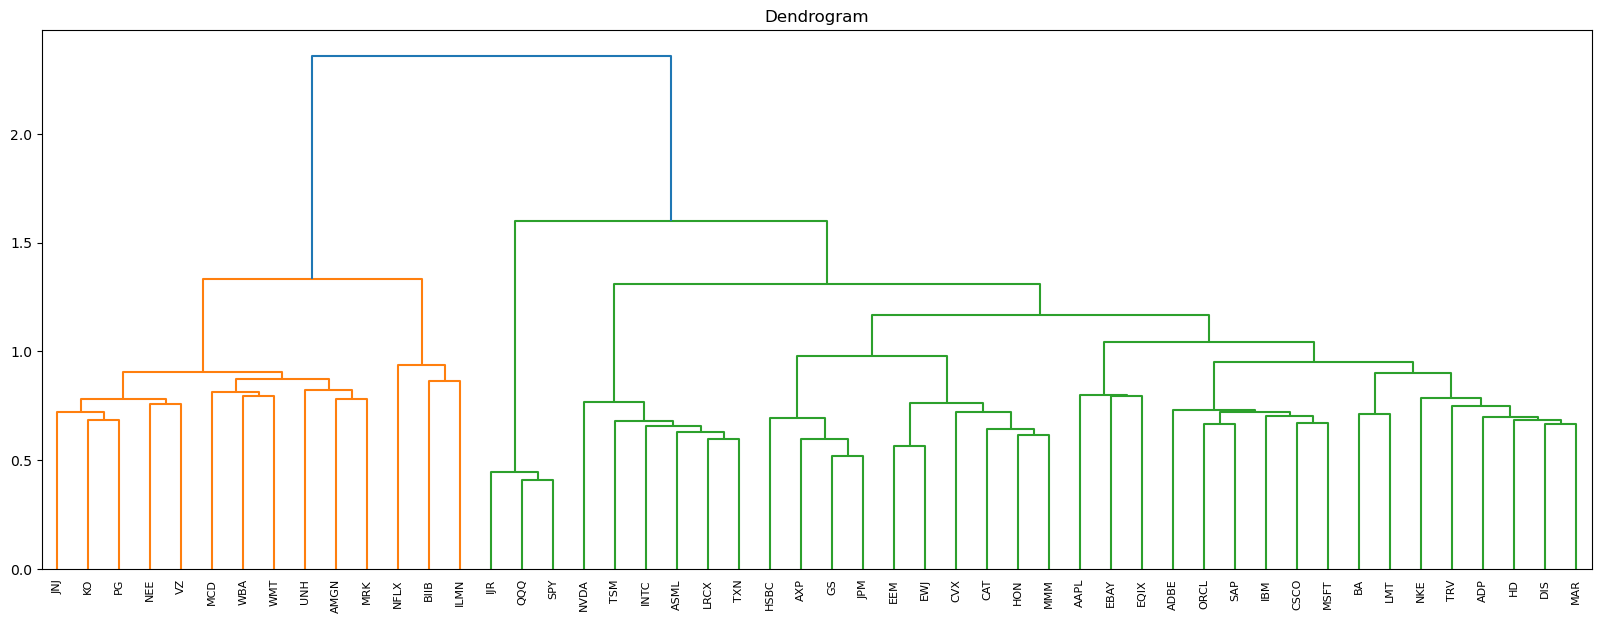

In [9]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendrogram")
dendrogram(link,labels = X.columns)
plt.show()

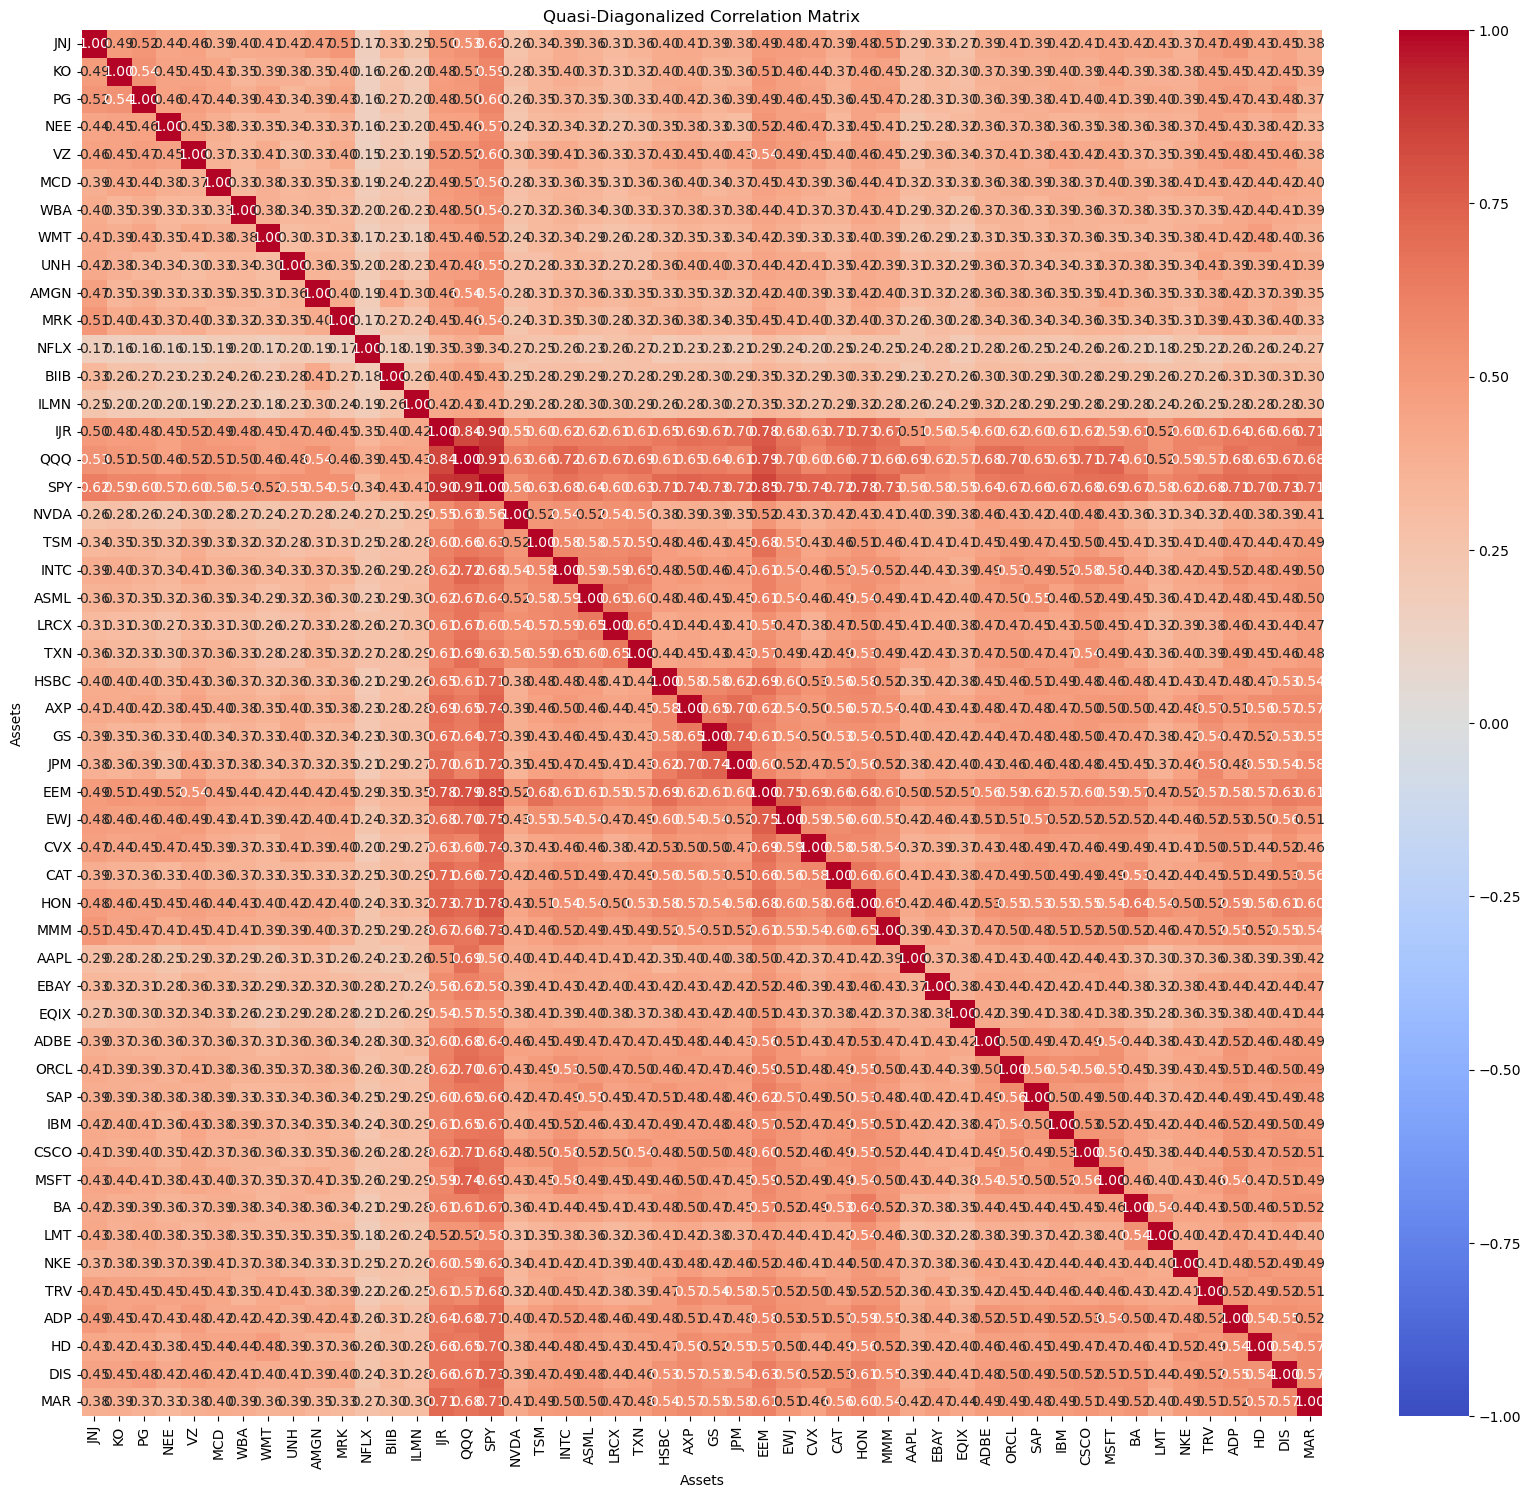

In [10]:
# Rearrange hierarchical clustering linkage to quasi-diagonal form
# Returns a list of indices that reorders the distance matrix for visualization

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx._append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

# Get quasi-diagonal index
quasi_diag_index = getQuasiDiag(link)

# Reorder rows and columns of the correlation matrix
quasi_diag_corr = returns.corr().iloc[quasi_diag_index, quasi_diag_index]

# Create a heatmap of the quasi-diagonalized correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(quasi_diag_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Quasi-Diagonalized Correlation Matrix')
plt.xlabel('Assets')
plt.ylabel('Assets')
plt.show()

In [11]:
# Calculate cluster variance using Inverse-Variance Portfolio (IVP) weights
# Uses equation: cVar = w'.cov.w where w is the IVP weight vector

def getClusterVar(cov,cItems):
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

# Compute HRP portfolio weights through recursive bisection
# Splits clusters and assigns weights based on variance contribution (α=1-V1/(V1+V2))

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


In [12]:
# Calculate Inverse Variance Portfolio (IVP) weights where w[i] = (1/σ[i]²)/Σ(1/σ[j]²)
# Returns optimal weights that minimize portfolio variance given asset volatilities

def getIVP(cov, **kargs): 
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [13]:
# Construct a HRP portfolio using correlation distances and linkage clustering
# Returns optimized portfolio weights by combining hierarchical clustering with recursive bisection

def getHRP(cov, corr):
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [14]:
# Generate portfolio weights using HRP
# Returns a dataFrame with HRP portfolio allocations using covariance and correlation

def get_all_portfolios(returns):
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    portfolios = pd.DataFrame([hrp], index=['HRP']).T
    return portfolios

In [15]:
portfolios = get_all_portfolios(returns)

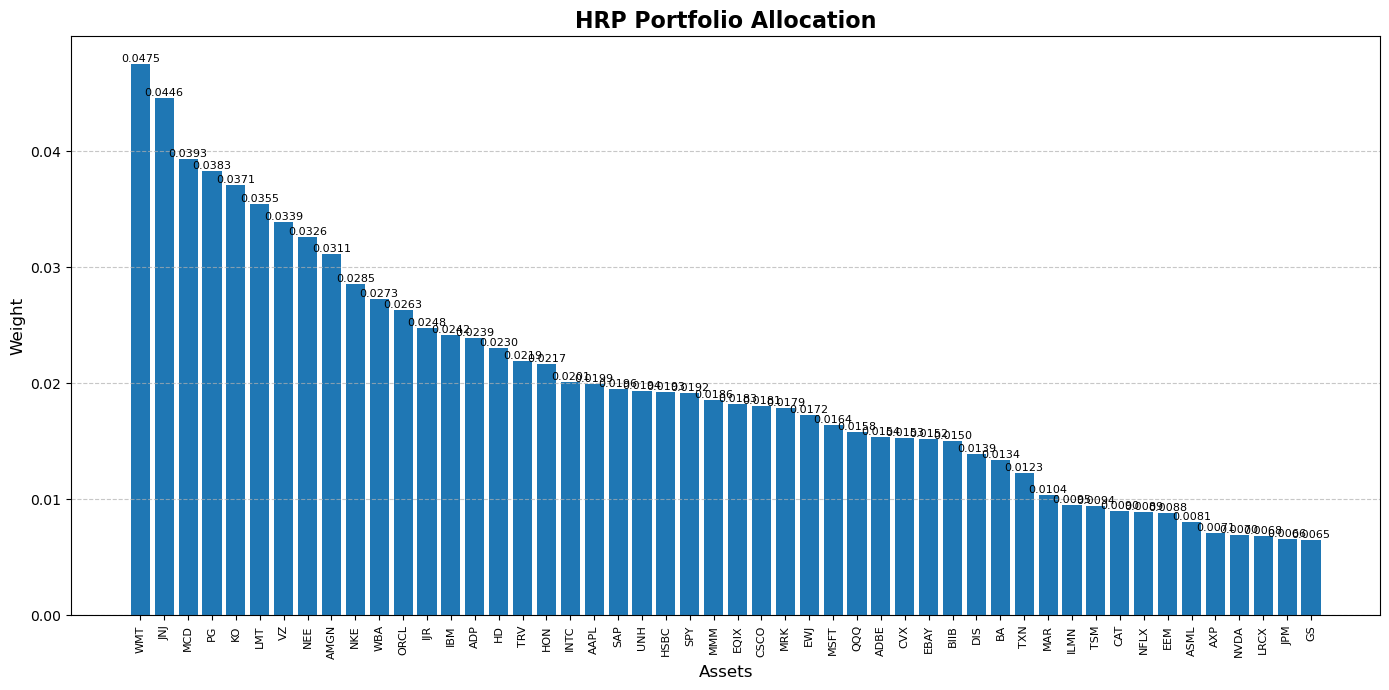

In [16]:
def plot_portfolio_allocation(portfolios, title, max_assets=50):
    # Ensure it's a series
    if isinstance(portfolios, pd.DataFrame):
        portfolios = portfolios.iloc[:, 0]  # Take the first column if it's a DataFrame
    
    # Sort and limit to top assets
    sorted_portfolio = portfolios.sort_values(ascending=False).head(max_assets)
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Create a bar plot using matplotlib (more efficient for large datasets)
    bars = ax.bar(range(len(sorted_portfolio)), sorted_portfolio.values)
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Assets', fontsize=12)
    ax.set_ylabel('Weight', fontsize=12)
    ax.set_xticks(range(len(sorted_portfolio)))
    ax.set_xticklabels(sorted_portfolio.index, rotation=90, ha='center', fontsize=8)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8)
    
    # Adjust layout and display gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot for training data
plot_portfolio_allocation(portfolios, "HRP Portfolio Allocation")


In [17]:
sorted_portfolio = portfolios.sort_values(by="HRP", ascending=False).head(10)
print(sorted_portfolio)

           HRP
WMT   0.047532
JNJ   0.044570
MCD   0.039329
PG    0.038288
KO    0.037130
LMT   0.035487
VZ    0.033874
NEE   0.032643
AMGN  0.031110
NKE   0.028532


In [18]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['HRP'], index = returns_test.index)

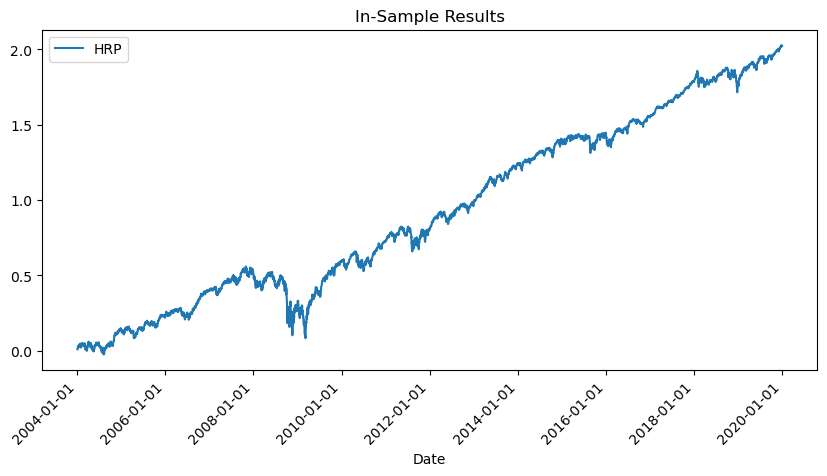

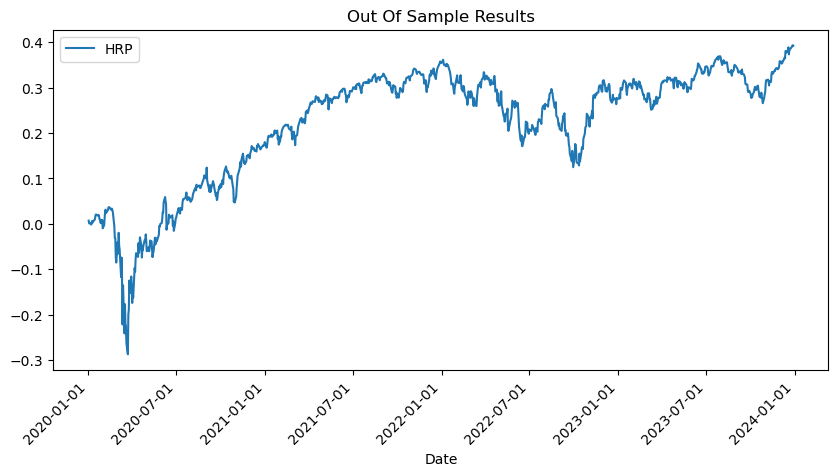

In [19]:
# Convert index to datetime 
Insample_Result.index = pd.to_datetime(Insample_Result.index)
OutOfSample_Result.index = pd.to_datetime(OutOfSample_Result.index)

# In-Sample Result Plot
fig, ax = plt.subplots(figsize=(10, 5))
Insample_Result.cumsum().plot(ax=ax, title="In-Sample Results")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

# Out-Of-Sample Result Plot
fig, ax = plt.subplots(figsize=(10, 5))
OutOfSample_Result.cumsum().plot(ax=ax, title="Out Of Sample Results")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [20]:
# In sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
HRP,0.162607,0.77839


In [21]:
# Out of Sample Results.

stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
HRP,0.203424,0.482823


#### Code References:

1) ADFT Lab Notebooks
2) https://www.kaggle.com/code/imoore/intro-to-exploratory-data-analysis-eda-in-python
3) https://www.kaggle.com/code/bhavyajoshi02022000/outlier-z-score-iqr
4) https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/5-Hierarchical-Risk-Parity.ipynb
5) https://github.com/TheRockXu/Hierarchical-Risk-Parity/blob/master/Hierarchical%20Clustering.ipynb
6) https://github.com/d-jiao/LSTM-For-Stock-Market-Prediction/blob/master/3_LSTM_Model.ipynb
7) https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm#6.-Predicting-the-closing-price-stock-price-of-APPLE-inc
8) https://www.kaggle.com/code/malingarajapaksha/stock-prediction-lstm#Modeling
9) https://www.kaggle.com/code/fredblair/transformers-for-stocks#Build-the-model
10) https://www.kaggle.com/code/selcukcan/nlp-9d-lstm-vs-transformers-for-stock-prediction#3.-Implementing-a-Transformer

